In [158]:
from lp_detection import calculate_distance
import numpy as np
import cv2
import imutils
import math
import matplotlib.pyplot as plt
from keras.models import load_model

Đọc dữ liệu đầu vào và thay đổi kích thước ảnh

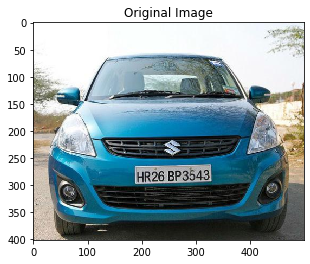

In [159]:

imager = cv2.imread('test_dataset/images/7.jpg')
image = imutils.resize(imager, width=500)
img = imutils.resize(imager, width=500)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.show()

Chuyển ảnh thành ảnh xám

Text(0.5, 1.0, 'Grayscale Conversion')

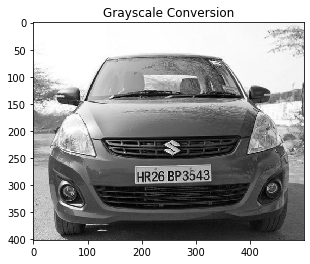

In [160]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.title('Grayscale Conversion')

Lọc nhiễu

Text(0.5, 1.0, 'Bilateral Filter')

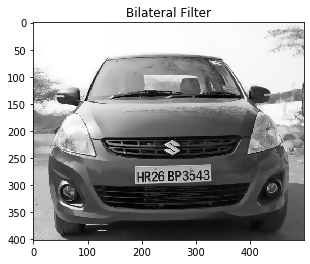

In [161]:
gray = cv2.bilateralFilter(gray, 11, 17, 17)
plt.imshow(gray, cmap='gray')
plt.title('Bilateral Filter')

Chuyển sang ảnh nhị phân và tìm cạnh

Text(0.5, 1.0, 'Canny Edges')

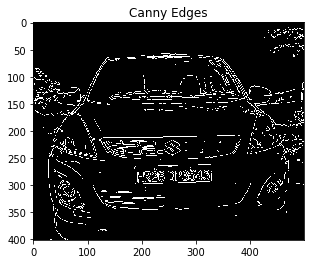

In [162]:
edged = cv2.Canny(gray, 170, 200)
plt.imshow(edged, cmap='gray')
plt.title('Canny Edges')

Tìm đường bao với Contours

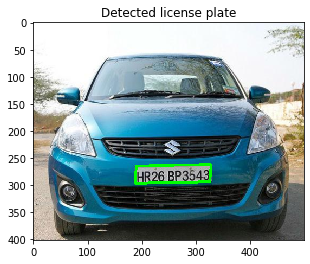

In [163]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] 
NumberPlateCnt = None
count = 0
for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:  
            NumberPlateCnt = approx 
            x,y,w,h = cv2.boundingRect(c)
            ROI = img[y:y+h, x:x+w]
            break

if NumberPlateCnt is not None:
    cv2.drawContours(image, [NumberPlateCnt], -1, (0,255,0), 3)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Detected license plate")
plt.show()

Tách biển

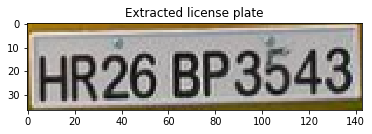

In [164]:

plt.imshow(ROI)
plt.title("Extracted license plate")
plt.show()

Xoay biển nếu biển nghiêng

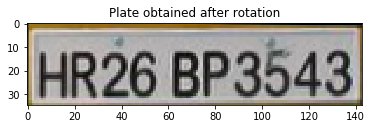

In [165]:
idx = 0
m = 0
for i in range(4):
    if NumberPlateCnt[i][0][1] > m:
        idx = i
        m = NumberPlateCnt[i][0][1]
if idx == 0:
    pin = 3
else:
    pin = idx-1
if idx == 3:
    nin = 0
else:
    nin = idx+1
p = calculate_distance(NumberPlateCnt[idx][0][0], NumberPlateCnt[pin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[pin][0][1])
n = calculate_distance(NumberPlateCnt[idx][0][0], NumberPlateCnt[nin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[nin][0][1])
if p > n:
    if NumberPlateCnt[pin][0][0] < NumberPlateCnt[idx][0][0]:
        left = pin
        right = idx
    else:
        left = idx
        right = pin
else:
    if NumberPlateCnt[nin][0][0] < NumberPlateCnt[idx][0][0]:
        left = nin
        right = idx
    else:
        left = idx
        right = nin
left_x = NumberPlateCnt[left][0][0]
left_y = NumberPlateCnt[left][0][1]
right_x = NumberPlateCnt[right][0][0]
right_y = NumberPlateCnt[right][0][1]
opp = right_y-left_y
hyp = ((left_x-right_x)**2+(left_y-right_y)**2)**0.5
sin = opp/hyp
theta = math.asin(sin)*57.2958
image_center = tuple(np.array(ROI.shape[1::-1]) / 2)
rot_mat = cv2.getRotationMatrix2D(image_center, theta, 1.0)
img_result = cv2.warpAffine(ROI, rot_mat, ROI.shape[1::-1], flags=cv2.INTER_LINEAR)
if opp > 0:
    h = img_result.shape[0]-opp//2
else:
    h = img_result.shape[0]+opp//2
img_result = img_result[0:h, :]
plt.imshow(img_result)
plt.title("Plate obtained after rotation")
plt.show()

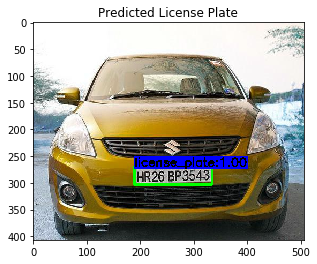

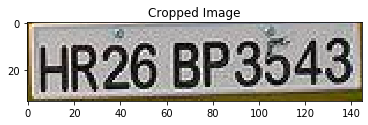

In [166]:

confThreshold = 0.5 
nmsThreshold = 0.4 

inputWidth = 416 
inputHeight = 416 

classesFile = str(r"yolo_utils/classes.names")
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

modelConfiguration = str(r"yolo_utils/darknet-yolov3.cfg")
modelWeights = str(r"yolo_utils/lapi.weights")

net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

def getOutputsNames(net):
    layersNames = net.getLayerNames()
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

def drawPred(classId, conf, left, top, right, bottom, frame):
    # ve bounding box
    cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)

    label = '%.2f' % conf

    # lay ra cac class
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    # ve du doan
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (0, 0, 255), cv2.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)

def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    cropped=None
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        
        # calculate bottom and right
        bottom = top + height
        right = left + width
        
        #crop the plate out
        cropped = frame[top:bottom, left:right].copy()
        # drawPred
        drawPred(classIds[i], confidences[i], left, top, right, bottom, frame)
    if cropped is not None:
        return cropped

imagery = cv2.imread('test_dataset/images/7.jpg')

# Create a 4D blob from a frame.
blob = cv2.dnn.blobFromImage(imagery, 1/255, (inputWidth, inputHeight), [0,0,0], 1, crop=False)

# Sets the input to the network
net.setInput(blob)

# Runs the forward pass to get output of the output layers
outs = net.forward(getOutputsNames(net))

# Remove the bounding boxes with low confidence
cropped = postprocess(imagery, outs)

plt.imshow(imagery)
plt.title("Predicted License Plate")
plt.show()
plt.imshow(cropped)
plt.title("Cropped Image")
plt.show()

Tiền xử lý phân đoạn biển số 

In [167]:

def segment_characters(image):

    img_lp = cv2.resize(image, (333, 75))
    plt.imshow(img_lp)
    plt.title('Image resize')
    plt.show()
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    plt.imshow(img_gray_lp)
    plt.title('Image gray')
    plt.show()
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    plt.imshow(img_binary_lp)
    plt.title('Image after binary')
    plt.show()
    img_binary_lp = cv2.erode(img_binary_lp, (3, 3))
    plt.imshow(img_binary_lp)
    plt.title('Image after erode')
    plt.show()
    img_binary_lp = cv2.dilate(img_binary_lp, (3, 3))
    plt.imshow(img_binary_lp)
    plt.title('Image after dilate')
    plt.show()
    
    img_binary_lp[0:3, :] = 255
    img_binary_lp[:, 0:3] = 255
    img_binary_lp[72:75, :] = 255
    img_binary_lp[:, 330:333] = 255
    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]
    dimensions = [LP_WIDTH/6, LP_WIDTH/2, LP_HEIGHT/10, 2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)
    img_gray_rw = cv2.imread('contour.jpg')
    contours, _ = cv2.findContours(img_binary_lp.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:15]
    x_contour_list = []  
    char_list = [] 
    for contour in contours:
        intX, intY, intWidth, intHeight = cv2.boundingRect(contour)
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height:
            x_contour_list.append(intX)
            char_copy = np.zeros((44, 24))
            char = img_binary_lp[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            cv2.rectangle(img_gray_rw, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(img_gray_rw, cmap='gray')
            plt.title('Predict Segments')
            char = cv2.subtract(255, char)
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0
            char_list.append(char_copy)

    indices = sorted(range(len(x_contour_list)), key=lambda k: x_contour_list[k])
    char_list_copy = []
    for idx in indices:
        char_list_copy.append(char_list[idx])
    char_list = np.array(char_list_copy)

    return char_list


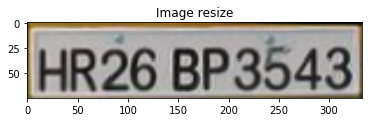

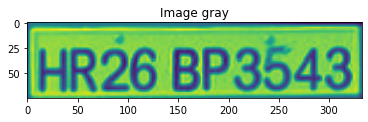

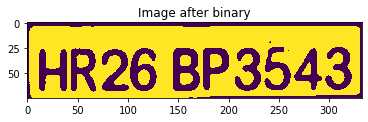

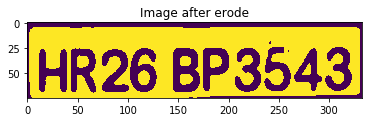

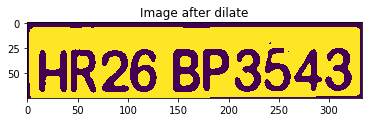

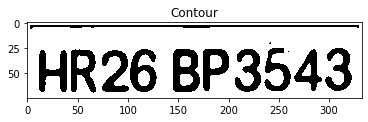

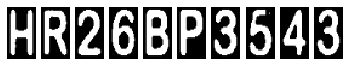

In [168]:
char=segment_characters(img_result)

for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.show()

Tách từng ký tự

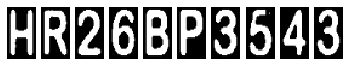

In [169]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.show()

Nhận dạng ký tự bằng cnn

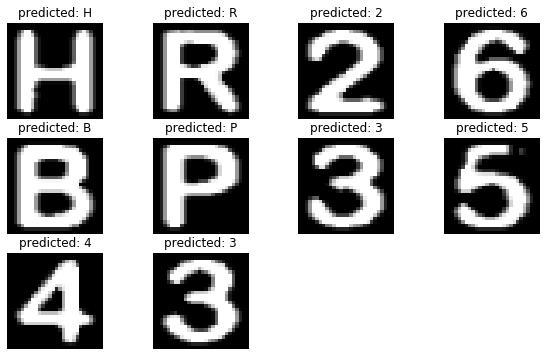

HR26BP3543


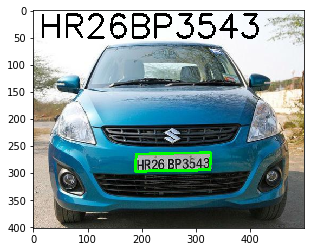

In [170]:
loaded_model = load_model('weights/best_model.h5')

def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
        return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = loaded_model.predict_classes(img)[0] #predicting the class
        character = dic[y_]
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

predict_plate = show_results()

plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

print(predict_plate)
cv2.putText(image, predict_plate, (10,50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,0),3,2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()